In [1]:
import os
import random
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation, SimpleRNN
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image
from PIL import UnidentifiedImageError

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import itertools
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
#upright = os.listdir(r'/content/drive/MyDrive/posture/Upright Sitting')
#Crossed_legs = os.listdir(r'/content/drive/MyDrive/posture/Crossing legs')
#slant_bending = os.listdir(r'/content/drive/MyDrive/posture/Slant Bending')
#Lordosis = os.listdir(r'/content/drive/MyDrive/posture/Lordosis')
#slouching = os.listdir(r'/content/drive/MyDrive/posture/Slouching')

#Sitting_Posture = os.listdir('C:/Users/Dell/Desktop/Sitting_Posture')
bending = os.listdir('C:/Users/Dell/Desktop/Human_posture/bending')
lying = os.listdir('C:/Users/Dell/Desktop/Human_posture/lying')
sitting = os.listdir('C:/Users/Dell/Desktop/Human_posture/sitting')
standing = os.listdir('C:/Users/Dell/Desktop/Human_posture/standing')


In [4]:
img_w, img_h = 150, 150 #setting the image width and height for easy processing
X = []
y = []

for i in bending:
    try:
        img = Image.open("C:/Users/Dell/Desktop/Human_posture/bending/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(0)
    except UnidentifiedImageError: # it passes an image that wasn't correctly identified
        pass
    
for i in lying:
    try:
        img = Image.open("C:/Users/Dell/Desktop/Human_posture/lying/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(1)
    except UnidentifiedImageError:
        pass
    
for i in sitting:
    try:
        img = Image.open("C:/Users/Dell/Desktop/Human_posture/sitting/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(2)
    except UnidentifiedImageError:
        pass
    
for i in standing:
    try:
        img = Image.open("C:/Users/Dell/Desktop/Human_posture/standing/" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(3)
    except UnidentifiedImageError:
        pass
    
    
    

X = np.asarray(X)
y = np.asarray(y)
print(X.shape, y.shape)

# I resized each image to our manually defined width and height(img_w, img_h)
# I also changed the images to an array



(4800, 150, 150, 3) (4800,)


In [5]:
x = X.astype('float32')
x /= 255

#scaler = MinMaxScaler()
#x = scaler.fit_transform(x)

num_classes = 4

labels = keras.utils.to_categorical(y, num_classes)
print(labels[0])

[1. 0. 0. 0.]


In [6]:
# splitting our dataset into train and test
x_train1, x_test, y_train1, y_test = train_test_split(x, labels, test_size = 0.2, random_state=5)
x_train,x_val,y_train,y_val=train_test_split(x_train1,y_train1,test_size=0.2,random_state=5)


print('Number of train: {}'.format(len(x_train)))
print('Number of validation: {}'.format(len(x_val)))
print('Number of test: {}'.format(len(x_test)))

Number of train: 3072
Number of validation: 768
Number of test: 960


In [7]:
datagen = ImageDataGenerator(
    rotation_range=20.,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=30.,
    zoom_range=0.2,
    horizontal_flip=0.2,
    rescale=None)

datagen.fit(x_train)

In [21]:
Res11 = tf.keras.applications.ResNet50(input_shape=(150,150,3),include_top=False,weights="imagenet")

In [22]:
for layer in Res11.layers:
    layer.trainable=False

In [25]:
# My neural network consists of 3 layers densely connected
# dropout helps prevent over fitting of the model when testing it
model_resnet=Sequential()
model_resnet.add(Res11)
model_resnet.add(Flatten())
model_resnet.add(Dense(128, activation='relu'))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(128, activation='relu'))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(4, activation='softmax'))
model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               6553728   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 4)                

In [26]:
# here i am defining my performance metrics to check the performance of the model
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

Metrics = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [31]:
lrd = ReduceLROnPlateau(monitor = 'recall',patience = 10,verbose = 1,factor = 0.70, min_lr = 1e-5)
# the above line of code reduces the learning rate when there is no improvement to the metric
# i added this line of code because i trained the model without it and the performance was stagnant
# the performance was stuck on 0.96nnn as the accuracy so i added the line of code to reduce
# the learing rate after two epochs
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=20

model_resnet.compile(optimizer='adam', loss = tf.keras.losses.CategoricalCrossentropy(),metrics=METRICS)

In [32]:
# this is where i fit and trained my model
%time
history=model_resnet.fit(x_train,y_train,validation_data=(x_val,y_val),epochs = 50,verbose = 1, callbacks=[lrd,mcp,es])

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/50
96/96 [==============================] - 445s 4s/step - loss: 1.2982 - accuracy: 0.4343 - precision: 0.6562 - recall: 0.2124 - auc: 0.7097 - f1_score: 0.3139 - val_loss: 0.8779 - val_accuracy: 0.6406 - val_precision: 0.9118 - val_recall: 0.4036 - val_auc: 0.8808 - val_f1_score: 0.5549 - lr: 0.0010
Epoch 2/50
96/96 [==============================] - 412s 4s/step - loss: 1.0154 - accuracy: 0.5208 - precision: 0.9019 - recall: 0.2754 - auc: 0.8096 - f1_score: 0.4156 - val_loss: 0.9334 - val_accuracy: 0.5846 - val_precision: 0.9907 - val_recall: 0.2760 - val_auc: 0.8584 - val_f1_score: 0.4266 - lr: 0.0010
Epoch 3/50
96/96 [==============================] - 405s 4s/step - loss: 0.9730 - accuracy: 0.5273 - precision: 0.9196 - recall: 0.2793 - auc: 0.8185 - f1_score: 0.4229 - val_loss: 0.8069 - val_accuracy: 0.6589 - val_precision: 0.9895 - val_recall: 0.3672 - val_auc: 0.9038 - val_f1_score: 0.5293 - lr: 0.0010
Epoch 4/50
96/96 [=============

In [33]:
Test_data = model_Inception.evaluate(x_test, y_test)

30/30 [==============================] - 60s 2s/step - loss: 1.4304 - accuracy: 0.4676 - precision: 0.9447 - recall: 0.2176 - auc: 0.7400 - f1_score: 0.0000e+00


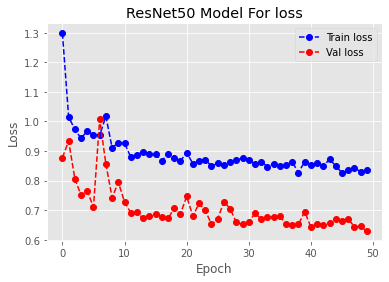

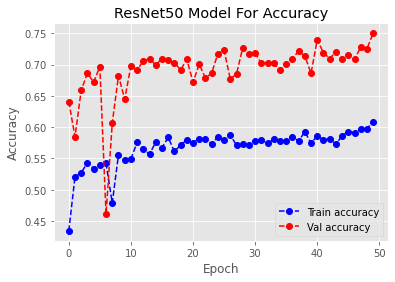

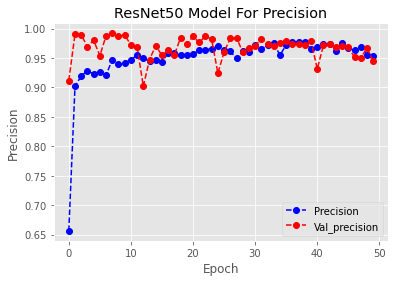

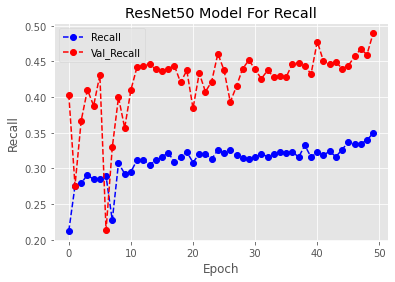

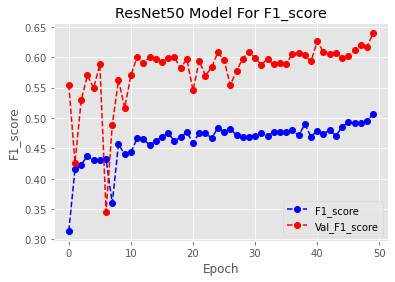

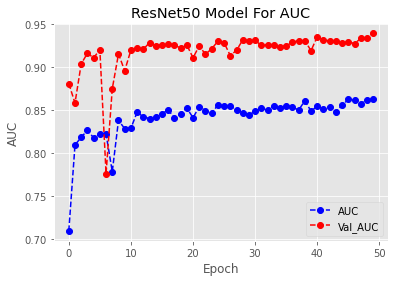

<Figure size 432x288 with 0 Axes>

In [34]:
#loss
plt.style.use("ggplot")
plt.plot(history.history['loss'], 'go--', c = "blue", label='Train loss')
plt.plot(history.history['val_loss'], 'go--', c = "red", label='Val loss')
plt.title('ResNet50 Model For loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

#accuracies
plt.plot(history.history['accuracy'], 'go--', c = "blue", label='Train accuracy')
plt.plot(history.history['val_accuracy'], 'go--', c = "red", label='Val accuracy')
plt.title('ResNet50 Model For Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.savefig('AccuracyVal_accuracy')


plt.plot(history.history['precision'], 'go--', c = "blue", label='Precision')
plt.plot(history.history['val_precision'], 'go--', c = "red", label='Val_precision')
plt.title('ResNet50 Model For Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend() 
plt.show()
plt.savefig('Precision_Scores')

         
plt.plot(history.history['recall'], 'go--', c = "blue", label='Recall')
plt.plot(history.history['val_recall'], 'go--', c = "red", label='Val_Recall')
plt.title('ResNet50 Model For Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.savefig('Recall_Scores')



plt.plot(history.history['f1_score'], 'go--', c = "blue", label='F1_score')
plt.plot(history.history['val_f1_score'], 'go--', c = "red", label='Val_F1_score')
plt.title('ResNet50 Model For F1_score')
plt.ylabel('F1_score')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.savefig('F1_Score')




plt.plot(history.history['auc'], 'go--', c = "blue", label='AUC')
plt.plot(history.history['val_auc'], 'go--', c = "red", label='Val_AUC')
plt.title('ResNet50 Model For AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.savefig('AUC')

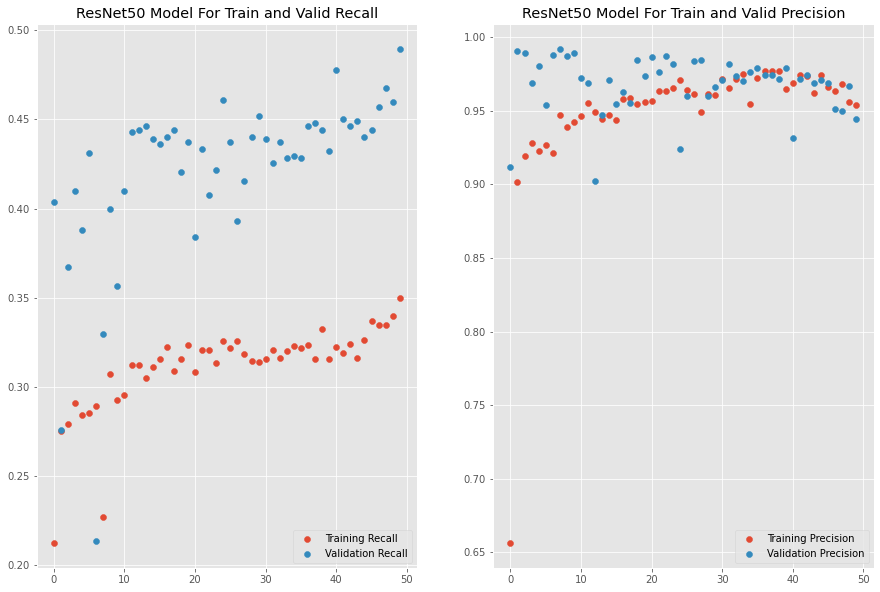

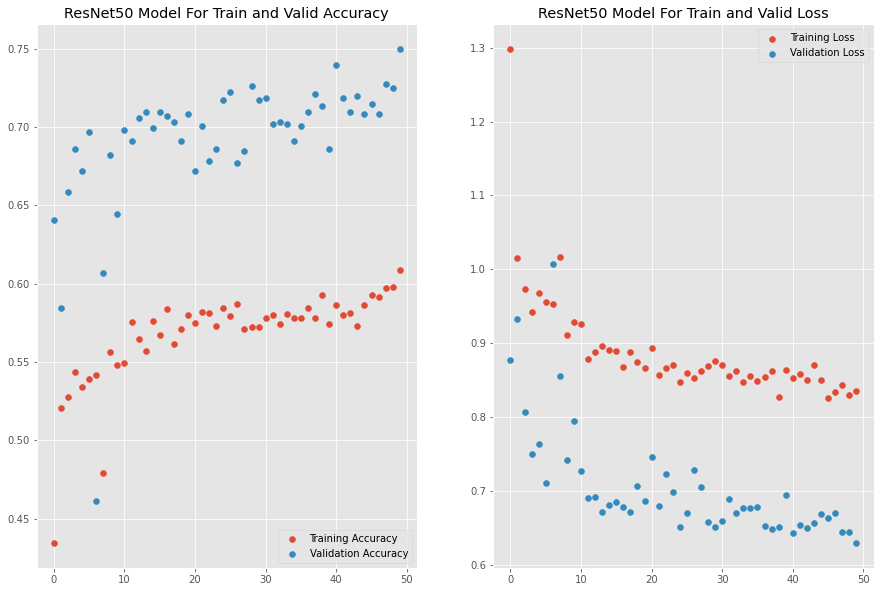

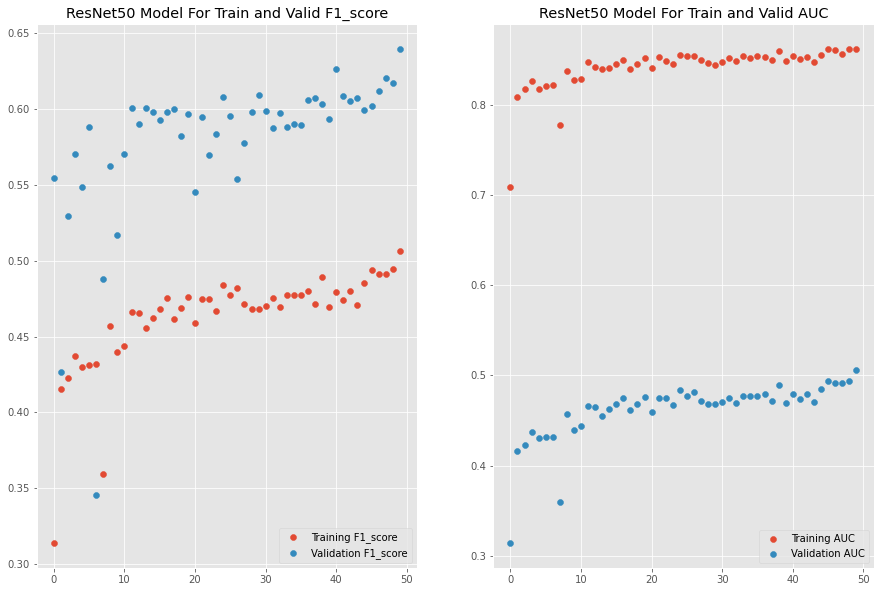

In [35]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['precision']
val_loss = history.history['val_precision']
epochs_range = range(len(history.history['val_precision']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range, acc, label='Training Recall')
plt.scatter(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('ResNet50 Model For Train and Valid Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range, loss, label='Training Precision')
plt.scatter(epochs_range, val_loss, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('ResNet50 Model For Train and Valid Precision')
plt.show()




acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range, acc, label='Training Accuracy')
plt.scatter(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('ResNet50 Model For Train and Valid Accuracy')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range, loss, label='Training Loss')
plt.scatter(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('ResNet50 Model For Train and Valid Loss')
plt.show()





acc = history.history['f1_score']
val_acc = history.history['val_f1_score']
loss = history.history['auc']
val_loss = history.history['val_auc']
epochs_range = range(len(history.history['val_auc']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range, acc, label='Training F1_score')
plt.scatter(epochs_range, val_acc, label='Validation F1_score')
plt.legend(loc='lower right')
plt.title('ResNet50 Model For Train and Valid F1_score')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range, loss, label='Training AUC')
plt.scatter(epochs_range, acc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('ResNet50 Model For Train and Valid AUC')
plt.show()

30/30 [==============================] - 54s 2s/step
ResNet50 Model Confusion Matrix
Classification Report
              precision    recall  f1-score   support

     bending       0.52      0.89      0.65       229
       lying       0.97      0.92      0.94       242
     sitting       0.68      0.21      0.32       247
    standing       0.88      0.94      0.91       242

    accuracy                           0.74       960
   macro avg       0.76      0.74      0.71       960
weighted avg       0.76      0.74      0.71       960



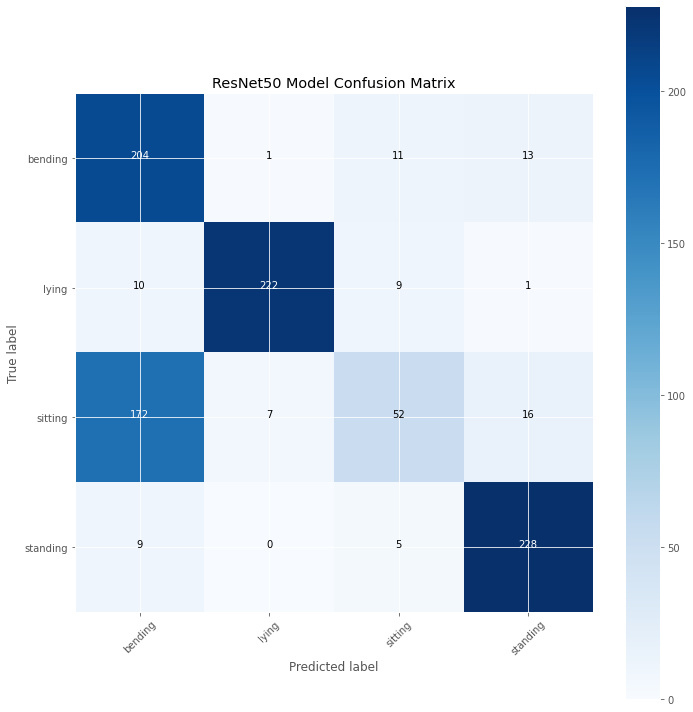

In [38]:
# here i want to define and plot my confusion matrix
# and also my classification report
def plot_confusion_matrix(cm, classes, normalize=True, title='ResNet50 Model Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
y_pred = (model_resnet.predict(x_test) > 0.5).astype("int32")

y_test_c = np.argmax(y_test, axis=1)
target_names = ["bending", "lying", "sitting", "standing"]

Y_pred = np.argmax(model_resnet.predict(x_test),axis=1)
print('ResNet50 Model Confusion Matrix')
cm = confusion_matrix(y_test_c, Y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='ResNet50 Model Confusion Matrix')

print('Classification Report')
print(classification_report(y_test_c, Y_pred, target_names=target_names))


30/30 [==============================] - 72s 2s/step
ResNet50 Model Confusion Matrix
Classification Report
              precision    recall  f1-score   support

     bending       0.52      0.89      0.65       229
       lying       0.97      0.92      0.94       242
     sitting       0.68      0.21      0.32       247
    standing       0.88      0.94      0.91       242

    accuracy                           0.74       960
   macro avg       0.76      0.74      0.71       960
weighted avg       0.76      0.74      0.71       960



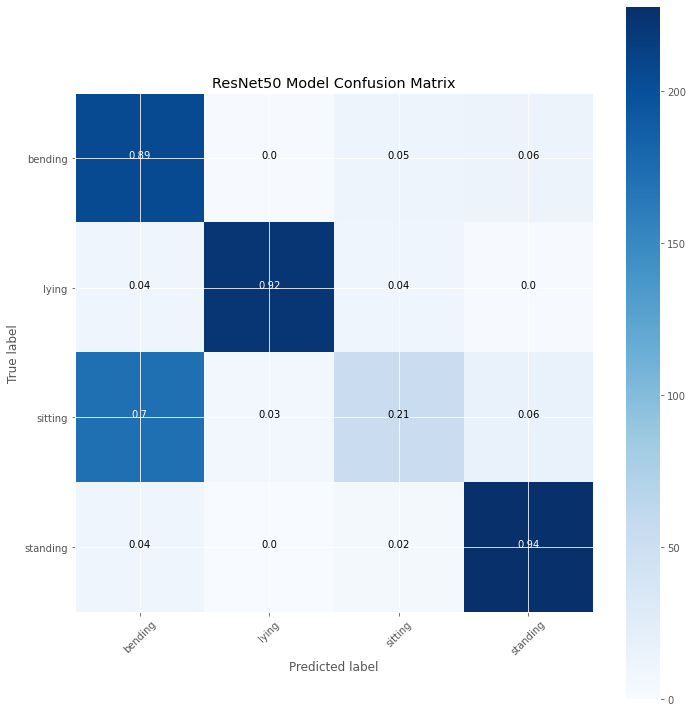

In [39]:
# here i want to define and plot my confusion matrix
# and also my classification report
def plot_confusion_matrix(cm, classes, normalize=True, title='ResNet50 Model Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
y_pred = (model_resnet.predict(x_test) > 0.5).astype("int32")

y_test_c = np.argmax(y_test, axis=1)
target_names = ["bending", "lying", "sitting", "standing"]

Y_pred = np.argmax(model_resnet.predict(x_test),axis=1)
print('ResNet50 Model Confusion Matrix')
cm = confusion_matrix(y_test_c, Y_pred)
plot_confusion_matrix(cm, target_names, normalize=True, title='ResNet50 Model Confusion Matrix')

print('Classification Report')
print(classification_report(y_test_c, Y_pred, target_names=target_names))
